In [16]:
import pandas as pd
import io
from google.colab import files
uploaded = files.upload()

# The uploaded file is a CSV, read it into a DataFrame
activity = next(iter(uploaded))
activity_data = uploaded[activity]
dat1 = pd.read_csv(io.BytesIO(activity_data))

Saving activity_data.csv to activity_data (1).csv


# Introduction & Research Purpose

**Research Objective:**

*   Observe shifts in macaque attention from new stimuli to known social activities over time.

*   Explore the evolutionary basis of these behaviors.

*   Analyze macaque behavior to infer human social development patterns.




#Data Summary & Description

In [ ]:
# Summarize data for the first two minutes
dat1_2mins = dat1[dat1['obs'] < 9]
dat1_2mins_summary = dat1_2mins.groupby(['subj_id', 'Day']).agg(
    acti_num=('Activity', 'sum'),
    active_intervals=('Activity', lambda x: (x > 0).sum()),
    age=('age', 'min')
).reset_index().rename(columns={'subj_id': 'monkey'})


# Summarize data for the first twenty minutes
dat1_20mins = dat1[dat1['obs'] < 81]
dat1_20mins_summary = dat1_20mins.groupby(['subj_id', 'Day']).agg(
    acti_num=('Activity', 'sum'),
    active_intervals=('Activity', lambda x: (x > 0).sum()),
    age=('age', 'min')
).reset_index().rename(columns={'subj_id': 'monkey'})

# Display the first few rows of the summary
print(dat1_20mins_summary.head())


   monkey  Day  acti_num  active_intervals  age
0       0    1      9881                42   29
1       0    2      6356                34   29
2      88    1     15833                43   29
3      88    2      4988                19   29
4     636    1       572                10   28


Our dataset contains behavioral observations of 243 monkeys ranging in age from 4 to 30 years.

For each individual, our data includes:

*   A unique identifier (Monkey ID)
*   Age (4-30)
*   The day of observation (1 or 2)
*   The count of active intervals within the initial two minutes (ranging from 0 to 8)
*   The count of active intervals within the entire twenty minutes (ranging from 0 to 80)


# Multilevel Model

The model we want to build is:

\begin{align*}
y_{ij} &\sim \mathcal{N}(\mu_j + \beta_{\text{age}} \text{age}_{ij} + \beta_{\text{day}} \text{day}_{ij} + \beta_{\text{age,day}} [\text{age} \times \text{day}]_{ij}, \sigma^2) \\
\mu_j &\sim \mathcal{N}(\mu + \beta_{\text{age}} \text{age}_j, \tau^2) \\
\mu &\sim p(\mu) \\
\beta &\sim p(\beta) \\
\tau &\sim p(\tau) \\
\sigma &\sim p(\sigma).
\end{align*}


# Prior Distributions

For our model, we will assume that all prior distributions follow a normal pattern.

In [ ]:
import pandas as pd
import numpy as np

# Center the age around its mean and scale it by 2*SD (twice the standard deviation)
dat1_20mins_summary['age_centered'] = dat1_20mins_summary['age'] - dat1_20mins_summary['age'].mean()
dat1_20mins_summary['age_scaled'] = dat1_20mins_summary['age_centered'] / (2 * dat1_20mins_summary['age'].std())

# For activity bins, we'll center around a chosen point, for example, the minimum plus 4, and scale by 4
dat1_20mins_summary['active_intervals_centered'] = dat1_20mins_summary['active_intervals'] - (dat1_20mins_summary['active_intervals'].min() + 4)
dat1_20mins_summary['active_intervals_scaled'] = dat1_20mins_summary['active_intervals_centered'] / 4


In [ ]:
import pymc as pm

with pm.Model() as model:
    # Priors for the model parameters
    mu_prior = pm.Normal('mu', mu=0, sigma=0.2)
    beta_age = pm.Normal('beta_age', mu=0, sigma=0.2)
    beta_day = pm.Normal('beta_day', mu=0, sigma=1)
    beta_age_day = pm.Normal('beta_age_day', mu=0, sigma=1)
    sigma = pm.HalfNormal('sigma', sigma=1)
    tau = pm.Exponential('tau', lam=1)

# Pre-experiment prophylaxis & Fitting the data


   monkey  day  total  active_bins  age
0       0    1   9881           42   29
1       0    2   6356           34   29
2      88    1  15833           43   29
3      88    2   4988           19   29
4     636    1    572           10   28
                            OLS Regression Results                            
Dep. Variable:            active_bins   R-squared:                       0.678
Model:                            OLS   Adj. R-squared:                  0.351
Method:                 Least Squares   F-statistic:                     2.073
Date:                Tue, 02 Apr 2024   Prob (F-statistic):           1.08e-08
Time:                        23:00:27   Log-Likelihood:                -774.96
No. Observations:                 485   AIC:                             2040.
Df Residuals:                     240   BIC:                             3065.
Df Model:                         244                                         
Covariance Type:            nonrobust            

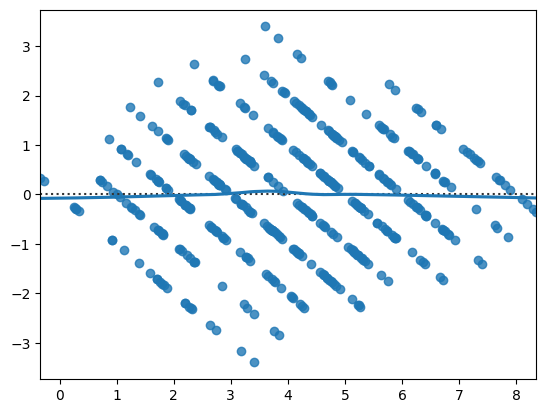

/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:848: RuntimeWarning: invalid value encountered in sqrt
  return self.resid / sigma / np.sqrt(1 - hii)


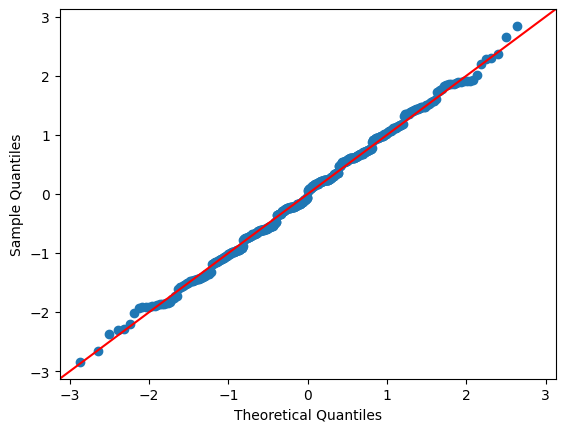

  monkey day  total  active_bins  age  age_centred  active_bins_scaled
0      0   1    495            6   29     0.552736                 0.5
1      0   2   1003            6   29     0.552736                 0.5
2     88   1   2642            8   29     0.552736                 1.0
3     88   2    524            6   29     0.552736                 0.5
4    636   1    199            2   28     0.514274                -0.5


/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


                         mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
intercept              -0.040  0.035  -0.107    0.022      0.001    0.001   
age_centred             0.037  0.108  -0.161    0.236      0.002    0.002   
age_centred:day2        0.110  0.119  -0.111    0.325      0.002    0.002   
day2                    0.104  0.039   0.030    0.175      0.001    0.000   
monkey_intercepts[0]    0.220  0.216  -0.147    0.648      0.003    0.004   
...                       ...    ...     ...      ...        ...      ...   
monkey_intercepts[240] -0.332  0.219  -0.733    0.077      0.003    0.003   
monkey_intercepts[241]  0.108  0.212  -0.299    0.491      0.003    0.005   
monkey_intercepts[242] -0.209  0.212  -0.595    0.201      0.003    0.004   
monkey_intercept_sd     0.308  0.030   0.247    0.359      0.001    0.001   
sigma                   0.428  0.020   0.392    0.464      0.001    0.000   

                        ess_bulk  ess_tail  r_hat  
intercept              

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


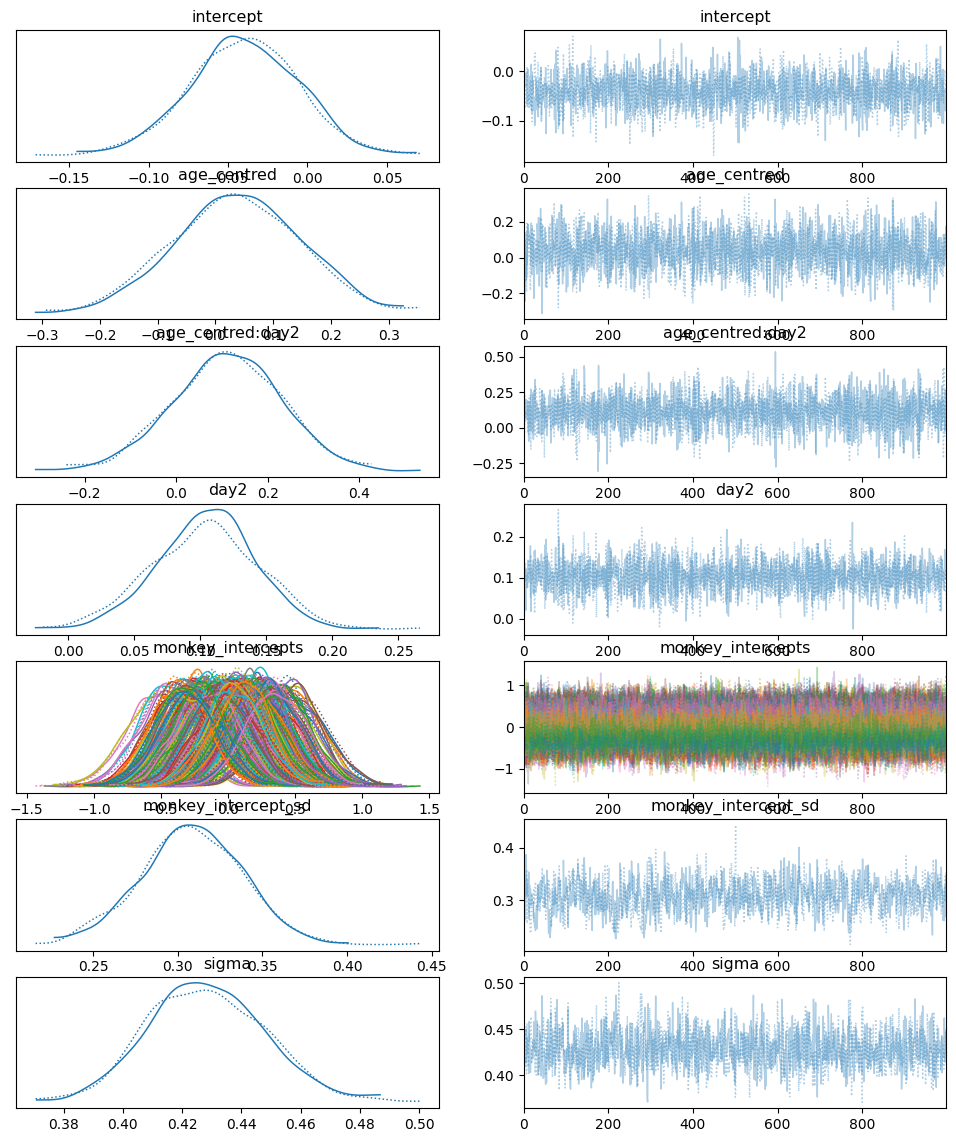

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from cmdstanpy import CmdStanModel
import arviz as az
import pymc as pm
# Load the data
acti_data = dat1
activity_2mins = (acti_data[acti_data['obs'] < 9]
                  .groupby(['subj_id', 'Day'])
                  .agg(total=('Activity', 'sum'),
                       active_bins=('Activity', lambda x: (x > 0).sum()),
                       age=('age', 'min'))
                  .reset_index()
                  .rename(columns={'subj_id': 'monkey', 'Day': 'day'}))
activity_20mins80 = (acti_data[acti_data['obs'] < 81]
                     .groupby(['subj_id', 'Day'])
                     .agg(total=('Activity', 'sum'),
                          active_bins=('Activity', lambda x: (x > 0).sum()),
                          age=('age', 'min'))
                     .reset_index()
                     .rename(columns={'subj_id': 'monkey', 'Day': 'day'}))

# Checking the data similar to glimpse()
print(activity_20mins80.head())

# Linear models with statsmodels
fit_lm = smf.ols('active_bins ~ age * C(day) + C(monkey)', data=activity_2mins).fit()
print(fit_lm.summary())

# Predictive checks and residuals similar to augment() and ggplot()
sns.residplot(x=fit_lm.fittedvalues, y=fit_lm.resid, lowess=True)
plt.show()

# Q-Q plot of standardized residuals
sm.qqplot(fit_lm.get_influence().resid_studentized_internal, line='45')
plt.show()
age_centre = activity_2mins['age'].mean()
age_scale = activity_2mins['age'].max() - activity_2mins['age'].min()
active_bins_centre = 4

activity_2mins['monkey'] = activity_2mins['monkey'].astype('category')
activity_2mins['day'] = activity_2mins['day'].astype('category')
activity_2mins['age_centred'] = (activity_2mins['age'] - age_centre) / age_scale
activity_2mins['active_bins_scaled'] = (activity_2mins['active_bins'] - active_bins_centre) / 4

print(activity_2mins.head())
age_center = activity_2mins['age'].mean()
age_scale = activity_2mins['age'].max() - activity_2mins['age'].min()
active_bins_center = 4  # This seems to be a constant you're using to center `active_bins`

activity_2mins['age_centred'] = (activity_2mins['age'] - age_center) / age_scale
activity_2mins['active_bins_scaled'] = (activity_2mins['active_bins'] - active_bins_center) / 4

# Now that we have scaled and centered the columns, let's rename it to activity_2mins_scaled
activity_2mins_scaled = activity_2mins.copy()

age_centred = activity_2mins_scaled['age_centred'].values
day = (activity_2mins_scaled['day'].astype(int) - 1).values  # convert day to 0 or 1
active_bins_scaled = activity_2mins_scaled['active_bins_scaled'].values
monkeys = pd.Categorical(activity_2mins_scaled['monkey']).codes

def build_model(age_centred, day, active_bins_scaled, monkeys):
    with pm.Model() as model:
        # Priors
        intercept_prior = pm.Normal('intercept', mu=0, sigma=1)
        age_centred_prior = pm.Normal('age_centred', mu=0, sigma=0.2)
        age_centred_day2_interaction_prior = pm.Normal('age_centred:day2', mu=0, sigma=0.2)
        day2_prior = pm.Normal('day2', mu=0, sigma=1)
        monkey_intercept_sd = pm.Exponential('monkey_intercept_sd', 1)
        monkey_intercepts = pm.Normal('monkey_intercepts', mu=0, sigma=monkey_intercept_sd, shape=len(np.unique(monkeys)))
        sigma_prior = pm.HalfNormal('sigma', sigma=1)

        # Model equation
        mu = (intercept_prior +
              age_centred_prior * age_centred +
              day2_prior * day +
              age_centred_day2_interaction_prior * age_centred * day +
              monkey_intercepts[monkeys])

        # Likelihood
        active_bins_likelihood = pm.Normal('active_bins', mu=mu, sigma=sigma_prior, observed=active_bins_scaled)

    return model

def simulate_prior_draws(model):
  with model:
    prior_draws = pm.sample_prior_predictive(samples=500)
  return prior_draws

# Begining of fitting the data
def compare_models(models_dict):
    comparison = az.compare(models_dict)
    return comparison

def build_nopool_model(age_centred, day, active_bins_scaled, monkeys):
    with pm.Model() as model_nopool:
        # Priors
        intercept = pm.Normal('intercept', mu=0, sigma=1)
        age_centred_coef = pm.Normal('age_centred', mu=0, sigma=1)
        day_coef = pm.Normal('day', mu=0, sigma=1)
        age_day_interaction = pm.Normal('age_centred:day', mu=0, sigma=1)
        monkey_coef = pm.Normal('monkey', mu=0, sigma=1, shape=len(np.unique(monkeys)))

        # Model equation
        mu = (intercept +
              age_centred_coef * age_centred +
              day_coef * day +
              age_day_interaction * age_centred * day +
              monkey_coef[monkeys])

        # Likelihood
        sigma = pm.HalfNormal('sigma', sigma=1)
        active_bins_likelihood = pm.Normal('active_bins', mu=mu, sigma=sigma, observed=active_bins_scaled)

    return model_nopool

def build_pool_model(age_centred, day, active_bins_scaled):
    with pm.Model() as model_pool:
        # Priors
        intercept = pm.Normal('intercept', mu=0, sigma=1)
        age_centred_coef = pm.Normal('age_centred', mu=0, sigma=1)
        day_coef = pm.Normal('day', mu=0, sigma=1)
        age_day_interaction = pm.Normal('age_centred:day', mu=0, sigma=1)

        # Model equation
        mu = (intercept +
              age_centred_coef * age_centred +
              day_coef * day +
              age_day_interaction * age_centred * day)

        # Likelihood
        sigma = pm.HalfNormal('sigma', sigma=1)
        active_bins_likelihood = pm.Normal('active_bins', mu=mu, sigma=sigma, observed=active_bins_scaled)

    return model_pool

age_centred = activity_2mins_scaled['age_centred'].values
day = (activity_2mins_scaled['day'].astype(int) - 1).values
active_bins_scaled = activity_2mins_scaled['active_bins_scaled'].values
monkeys = pd.Categorical(activity_2mins_scaled['monkey']).codes

model = build_model(age_centred, day, active_bins_scaled, monkeys)
with model:
      trace = pm.sample(tune=2000, return_inferencedata=True)

summary_stats = az.summary(trace)
posterior_draws = summary_stats['mean']
print(summary_stats)
az.plot_trace(trace)
plt.show()

def main():
    prior_draws = simulate_prior_draws(model)
    if 'intercept' in prior_draws:
        sns.kdeplot(prior_draws['intercept'], label='Intercept Prior Distribution')
        plt.show()

if __name__ == '__main__':
    main()




# Post-experiment

Posterior checks - Predictions

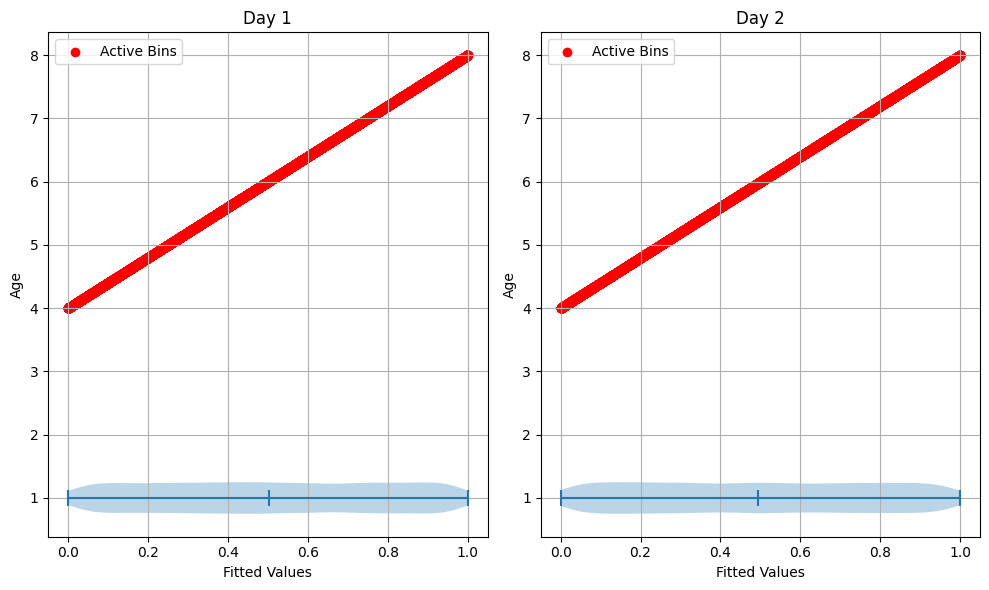

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Dummy DataFrame for demonstration
fitted = pd.DataFrame(np.random.rand(100, 200))  # Assuming 100 rows and 200 columns of fitted values
fitted['age'] = np.random.randint(20, 50, size=100)  # Adding 'age' column as an example
fitted['day'] = np.random.choice(['Day 1', 'Day 2'], size=100)  # Adding 'day' column as an example

# Define day labels
day_labs = {"Day 1": "Day 1", "Day 2": "Day 2"}

# Reshape fitted values into a long format
fitted_long = fitted.melt(id_vars=['age', 'day'], var_name='draw', value_name='fitted')

# Map day labels to day numbers
fitted_long['day'] = fitted_long['day'].map(day_labs)

# Plot violin plot
plt.figure(figsize=(10, 6))
for i, (day, data) in enumerate(fitted_long.groupby('day'), 1):
    plt.subplot(1, 2, i)  # Use the index 'i' instead of 'int(day)'
    plt.violinplot(data['fitted'], showmeans=True, showextrema=True, vert=False)
    plt.scatter(data['fitted'], 4 * data['fitted'] + active_bins_centre, color='red', label='Active Bins')
    plt.xlabel('Fitted Values')
    plt.ylabel('Age')
    plt.title(day)
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.show()


Non-linearity in "age"

    monkey day  total  active_bins  age  age_centred  active_bins_scaled  \
0        0   1    495            6   29     0.552736                0.50   
1        0   2   1003            6   29     0.552736                0.50   
2       88   1   2642            8   29     0.552736                1.00   
3       88   2    524            6   29     0.552736                0.50   
4      636   1    199            2   28     0.514274               -0.50   
..     ...  ..    ...          ...  ...          ...                 ...   
480  22060   2      0            0   19     0.168121               -1.00   
481  22062   1    529            6   21     0.245044                0.50   
482  22062   2    207            4   21     0.245044                0.00   
483  22064   1    290            2   21     0.245044               -0.50   
484  22064   2    136            3   21     0.245044               -0.25   

     fitted_mean  
0       0.003787  
1       0.003787  
2       0.003787  
3       0.0

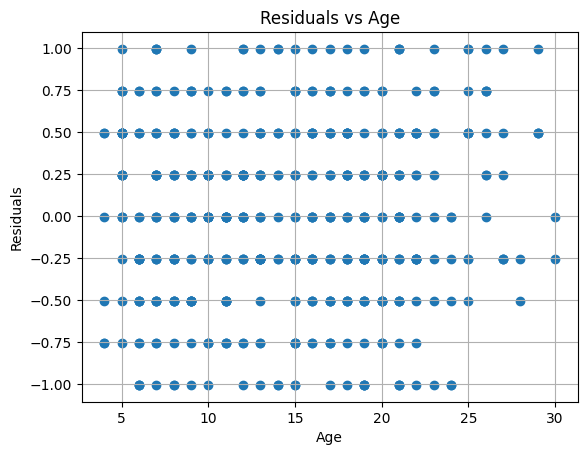

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Calculate fitted mean
fitted_mean = np.mean(posterior_draws, axis=0)  # Assuming each row in posterior_draws is a draw


# Create plot_data DataFrame
plot_data = activity_2mins_scaled.copy()
plot_data['fitted_mean'] = fitted_mean
print(plot_data)


# Plot the data
plt.scatter(plot_data['age'], plot_data['active_bins_scaled'] - plot_data['fitted_mean'])
plt.xlabel('Age')
plt.ylabel('Residuals')
plt.title('Residuals vs Age')
plt.grid(True)
plt.show()


The residuals vs the fitted values

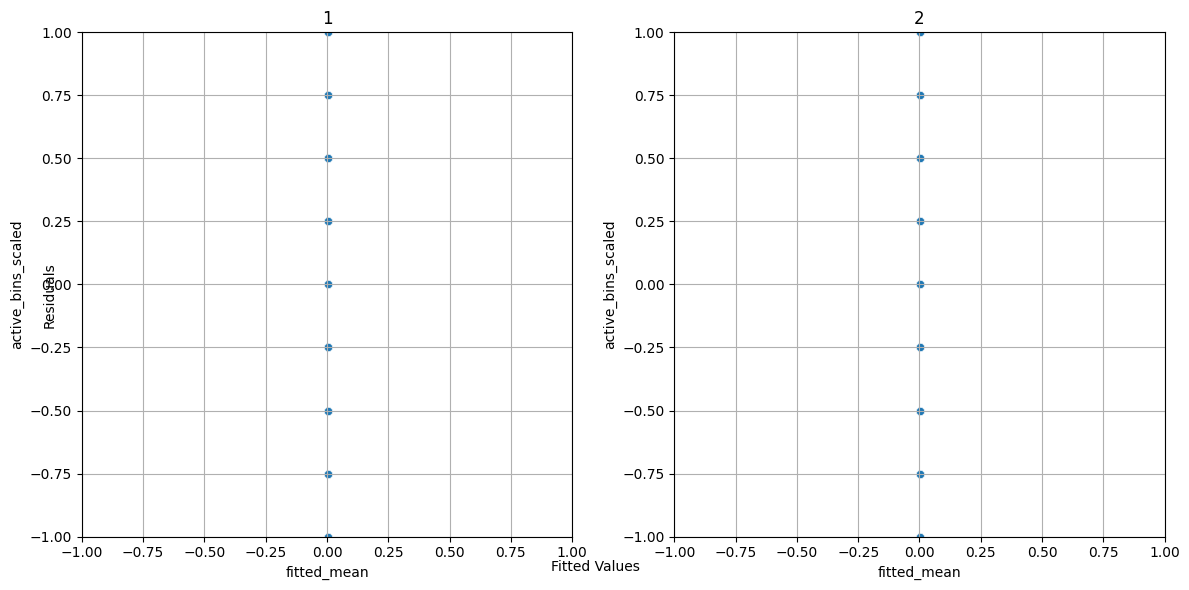

In [23]:
import seaborn as sns

# Create two subplots for each day
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Iterate over each day and create the respective plot
for i, (day, data) in enumerate(plot_data.groupby('day')):
    # Scatter plot of residuals vs fitted values
    sns.scatterplot(x='fitted_mean', y='active_bins_scaled', data=data, ax=axes[i])
    # Add dashed regression line
    sns.regplot(x='fitted_mean', y='active_bins_scaled', data=data, scatter=False, ax=axes[i], line_kws={"linestyle": "--", "color": "blue"})
    # Set plot title
    axes[i].set_title(f'{day}')
    # Set plot limits
    axes[i].set_xlim(-1, 1)
    axes[i].set_ylim(-1, 1)
    # Add gridlines to the subplot
    axes[i].grid(True)

# Set common labels
fig.text(0.5, 0.04, 'Fitted Values', ha='center')
fig.text(0.04, 0.5, 'Residuals', va='center', rotation='vertical')

# Show plot
plt.tight_layout()
plt.show()


Simulate new data from a correctly specified model that matches activity_data

In [ ]:
import numpy as np
import pandas as pd
import pymc as pm

# Step 1: Generate monkey_effect
unique_monkeys = activity_2mins_scaled['monkey'].unique()
monkey_effect = pd.DataFrame({
    'monkey': unique_monkeys,
    'monkey_effect': np.random.normal(0, 0.31, len(unique_monkeys))
})

# Step 2: Merge monkey_effect with activity_2mins_scaled
data_sim = pd.merge(activity_2mins_scaled, monkey_effect, on='monkey', how='left')

# Step 3: Generate active_bins_scaled
def generate_active_bins_scaled(row):
    mean = -0.04 + 0.01 * row['age_centred'] + row['monkey_effect']
    if row['day'] == 2:
        mean += 0.1 + 0.085 * row['age_centred']
    return np.random.normal(mean, 0.43)

data_sim['active_bins_scaled'] = data_sim.apply(generate_active_bins_scaled, axis=1)

# Step 4: Define the PyMC model
with pm.Model() as model:
    # Priors
    intercept = pm.Normal('intercept', mu=0, sigma=1)
    age_centred_coef = pm.Normal('age_centred', mu=0, sigma=1)
    monkey_effect = pm.Normal('monkey_effect', mu=0, sigma=0.31, shape=len(data_sim['monkey'].unique()))
    sd = pm.HalfNormal('sd', sigma=0.43)

    # Model equation
    mean = (
        intercept +
        age_centred_coef * data_sim['age_centred'] +
        pm.math.sum(monkey_effect[data_sim['monkey'].cat.codes], axis=0) +
        pm.math.switch(data_sim['day'] == 2, 0.1 + 0.085 * data_sim['age_centred'], 0.0)
    )

    # Likelihood
    active_bins_scaled = pm.Normal('active_bins_scaled', mu=mean, sigma=sd, observed=data_sim['active_bins_scaled'])

    # Sample the posterior
    trace = pm.sample(2000, tune=1000)

# Step 5: Summarize the posterior
summary = pm.summary(trace)
posterior_draws_sim = summary['mean']
print(posterior_draws_sim)
print(summary)


intercept            -0.010
age_centred           0.147
monkey_effect[0]     -0.003
monkey_effect[1]      0.003
monkey_effect[2]      0.005
                      ...  
monkey_effect[239]    0.002
monkey_effect[240]   -0.003
monkey_effect[241]    0.000
monkey_effect[242]    0.003
sd                    0.519
Name: mean, Length: 246, dtype: float64
                     mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
intercept          -0.010  1.013  -1.809    2.000      0.013    0.018   
age_centred         0.147  0.099  -0.045    0.318      0.001    0.001   
monkey_effect[0]   -0.003  0.302  -0.567    0.563      0.004    0.005   
monkey_effect[1]    0.003  0.313  -0.561    0.597      0.004    0.005   
monkey_effect[2]    0.005  0.303  -0.546    0.589      0.004    0.005   
...                   ...    ...     ...      ...        ...      ...   
monkey_effect[239]  0.002  0.307  -0.576    0.592      0.004    0.005   
monkey_effect[240] -0.003  0.313  -0.582    0.603      0.004    0.00

Below is the violin plot,

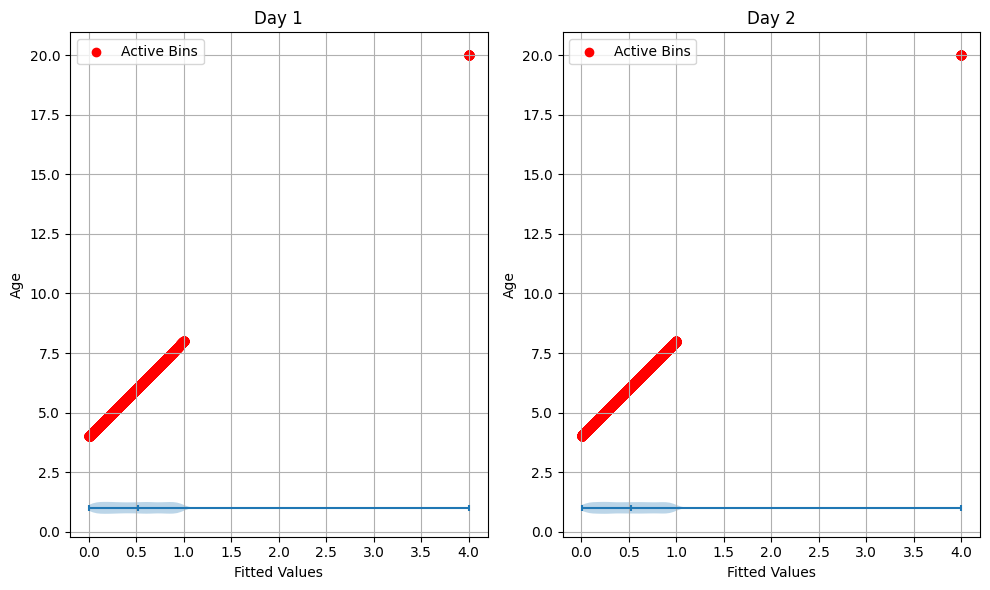

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Create a data frame with random data
fitted_sim = pd.DataFrame(np.random.rand(100, 200))
fitted_sim['age'] = np.random.randint(20, 50, size=100) # Adding 'age' column as an example
fitted_sim['day'] = np.random.choice(['Day 1', 'Day 2'], size=100) # Adding 'day' column as an example
fitted_sim['active_bins_centre'] = 4  # Adding 'active_bins_centre' column with a constant value

# Convert the DataFrame to long format
fitted_sim_long = fitted_sim.melt(id_vars=['age', 'day'], var_name='draw', value_name='fitted')

# Day labels, same as before
day_labs = {"Day 1": "Day 1", "Day 2": "Day 2"}

# Map day labels to day numbers
fitted_sim_long['day'] = fitted_sim_long['day'].map(day_labs)

# Plot violin plot
plt.figure(figsize=(10, 6))
for i, (day, data_sim) in enumerate(fitted_sim_long.groupby('day'), 1):
    plt.subplot(1, 2, i)
    plt.violinplot(data_sim['fitted'], showmeans=True, showextrema=True, vert=False)

    # Create an array of the same length as 'data_sim['fitted']' with the same constant value
    active_bins_centre_array = np.full_like(data_sim['fitted'], fitted_sim['active_bins_centre'].iloc[0])

    plt.scatter(data_sim['fitted'], 4 * data_sim['fitted'] + active_bins_centre_array, color='red', label='Active Bins')
    plt.xlabel('Fitted Values')
    plt.ylabel('Age')
    plt.title(day)
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.show()

Plot of residuals ordered by age,

    monkey day  total  active_bins  age  age_centred  active_bins_scaled  \
0        0   1    495            6   29     0.552736                0.50   
1        0   2   1003            6   29     0.552736                0.50   
2       88   1   2642            8   29     0.552736                1.00   
3       88   2    524            6   29     0.552736                0.50   
4      636   1    199            2   28     0.514274               -0.50   
..     ...  ..    ...          ...  ...          ...                 ...   
480  22060   2      0            0   19     0.168121               -1.00   
481  22062   1    529            6   21     0.245044                0.50   
482  22062   2    207            4   21     0.245044                0.00   
483  22064   1    290            2   21     0.245044               -0.50   
484  22064   2    136            3   21     0.245044               -0.25   

     monkey_effect  fitted_mean_sim  
0        -0.128891         0.002337  
1        -0

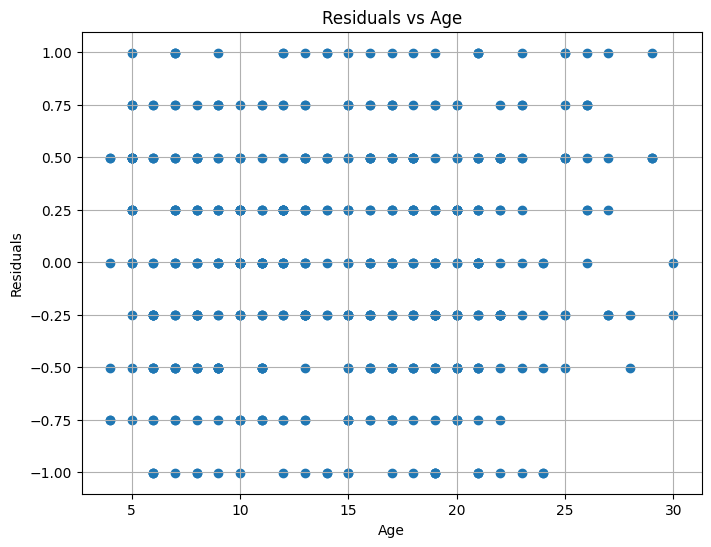

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Calculate fitted mean
fitted_mean_sim = np.mean(posterior_draws_sim, axis=0)  # Assuming each row in posterior_draws_sim is a draw

# Create plot_data DataFrame
plot_data_sim = data_sim.copy()
plot_data_sim['fitted_mean_sim'] = fitted_mean_sim
print(plot_data_sim)

# Plot the data

plt.figure(figsize=(8, 6))
plt.scatter(plot_data_sim['age'], plot_data_sim['active_bins_scaled'] - plot_data_sim['fitted_mean_sim'])
plt.xlabel('Age')
plt.ylabel('Residuals')
plt.title('Residuals vs Age')
plt.grid(True)
plt.show()


Residual vs. Plotted

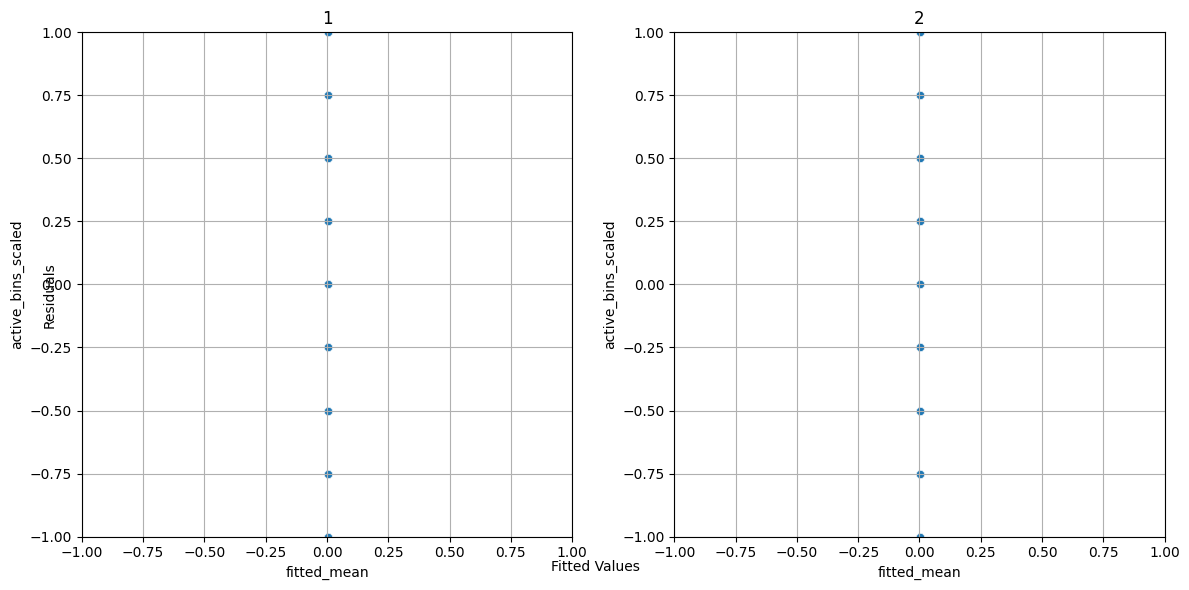

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create two subplots for each day
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Iterate over each day and create the respective plot
for i, (day, data_sim) in enumerate(plot_data.groupby('day')):
    # Scatter plot of residuals vs fitted values
    sns.scatterplot(x='fitted_mean', y='active_bins_scaled', data=data_sim, ax=axes[i])
    # Add dashed regression line
    sns.regplot(x='fitted_mean', y='active_bins_scaled', data=data_sim, scatter=False, ax=axes[i], line_kws={"linestyle": "--", "color": "blue"})
    # Set plot title
    axes[i].set_title(f'{day}')
    # Set plot limits
    axes[i].set_xlim(-1, 1)
    axes[i].set_ylim(-1, 1)
    # Add gridlines to the subplot
    axes[i].grid(True)

# Set common labels
fig.text(0.5, 0.04, 'Fitted Values', ha='center')
fig.text(0.04, 0.5, 'Residuals', va='center', rotation='vertical')

# Show plot
plt.tight_layout()
plt.show()

Both the residual and plotted look approximately the same.

# **Conclusion**

In our analysis, we focused on implementing and scrutinizing a Bayesian multilevel model, with particular attention given to overcoming obstacles related to graphical diagnostics for structured data. We emphasized the importance of the residual-vs-fitted plot in the context of multilevel models, elucidating its nuances for interpretation. A key insight gleaned from our investigation is the value of utilizing synthetic data derived from the posterior model to improve diagnostic understanding.

In scenarios without pooling, the estimates for each monkey ($\mu_j$) are essentially derived from averaging observations. Upon repetition, these estimates are unbiased, resulting in residuals ($r_{ij}$) with a mean of zero. However, the introduction of a magical number ($\alpha$), contingent on factors such as $\tau$, $\sigma$, and $n_j$, alters this dynamic. The modified estimate $\hat{\mu}_j$ combines the naive average $\bar{y}_j$ with the global average $\mu$, leading to residuals ($r_{ij}$) deviating from a mean of zero.

Upon further examination, it becomes evident that the model tends to centralize extreme groups, contributing to the positive slope observed in residuals versus fitted values. While this trend may appear pronounced, especially in small groups, there's no universally effective method to mitigate it, as suggested by Jim Hodges. Nonetheless, the plot remains a valuable tool for detecting outliers and heteroskedasticity, albeit requiring a nuanced interpretation.

In our current analysis, the absence of extreme outliers suggests the validity of our approach. However, with partial pooling, our methodology combines the naive average $\bar{y}_j$ with the global average $\mu$, accounting for group size and within-group variability relative to between-group variability.

The discrete nature of the data can indeed impact distributional diagnostics, potentially influencing the effectiveness of our model. While our current diagnostics didn't raise significant concerns, exploring alternative likelihoods tailored to the specific characteristics of the problem could offer valuable insights.

Adapting the likelihood to better suit the problem at hand can enhance the model's ability to capture the nuances of the data and improve its predictive performance. By considering the unique features of the dataset, such as its discrete nature, we can develop a more tailored approach that better reflects the underlying distribution and accounts for any peculiarities or complexities present.

Exploring alternative likelihoods in this context could lead to a deeper understanding of the data-generating process and help identify any potential limitations or areas for improvement in our current modeling framework.

# **References**

Dataset -

Bliss-Moreau, Eliza; Baxter, Mark (2020). Data from: Interest in nonsocial novel stimuli as a function of age in rhesus monkeys [Dataset]. Dryad. https://doi.org/10.5061/dryad.1bj133v